# Gaussian Naive Bayes from scratch

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import missingno as msno
from math import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import seaborn as sns

This will show confussion matrix in a tabular format

In [2]:
def showConfussionMatrix(y_test, y_pred, mytitle):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(3,3))
    disp.plot(ax=ax)
    disp.ax_.set(title=mytitle)

## Encoding Class Variable

Encoding class variable will convert string to numerical type column, this function also creates a small encoded dataframe which can be referred for understanding the predicted output. Benefit of using this function is that, class variable need not be present at the last column of df (function takes care of it).

In [3]:
def encodeClassVariable(df, colName):
    df = df.rename(columns={colName:'class'})
    encoder = LabelEncoder()
    df['class_code'] = encoder.fit_transform(df['class'])
    encoded_df = df[['class', 'class_code']].copy()
    df.pop('class')
    encoded_df.drop_duplicates(subset=None, keep="first", inplace=True)
    return encoded_df, df

## My Gnb class

In [37]:
class MyGnb:
    # Seperating the dataset by class value into a dictionary and then 
    # calculating mean, standard deviation and count of each column of dataset
    def fit(self, df_x, df_y):
        sep_dict = {}
        for i in range(len(df_y)):
            if df_y[i] not in sep_dict:
                sep_dict[df_y[i]] = []
            sep_dict[df_y[i]].append(df_x[i])
        self.summaries = {}
        for class_value, rows in sep_dict.items():
            summary = [(self.mean(column), self.stdev(column), len(column)) for column in zip(*rows)]
            self.summaries[class_value] = summary
        return self.summaries
    
    # Calculating the mean of numbers
    def mean(self, nums):
        return sum(nums)/float(len(nums))

    # Calculating standard deviation of numbers
    def stdev(self, nums):
        var = sum([(x-(self.mean(nums)))**2 for x in nums]) / float(len(nums)-1)
        return sqrt(var)
    
    
    # Predicting the class for the given test dataframe (rows)
    def predict(self, rows):
        res = []
        for row in rows:
            proba = self.calculate_class_proba(row)
            best_label, best_prob = None, -1
            for class_value, proba in proba.items():
                if best_label is None or proba > best_prob:
                    best_prob = proba
                    best_label = class_value
            res.append(best_label)
        return res
    
    # Calculating the probabilities of predicting every class for a given row
    def calculate_class_proba(self, row):
        total_rows = sum(self.summaries[label][0][2] for label in self.summaries)
        probabilities = {}
        for class_value, class_summaries in self.summaries.items():
            probabilities[class_value] = self.summaries[class_value][0][2]/float(total_rows)
            for i in range(len(class_summaries)):
                mean, stdev, count = class_summaries[i]
                probabilities[class_value] *= self.calculate_proba(row[i], mean, stdev)
        return probabilities
    
    # Calculating Gaussian probability distribution function for x
    def calculate_proba(self, x, mean, stdev):
        exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
        return (1 / (sqrt(2 * pi) * stdev)) * exponent

### 
---

## Penguins Dataset

In [43]:
df = pd.read_csv('data\penguins_af.csv')
f_names = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'body_mass_g']
df = df[f_names + ['species']]
df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
0,39.1,18.7,181.0,3750.0,Adelie
1,39.5,17.4,186.0,3800.0,Adelie
2,40.3,18.0,195.0,3250.0,Adelie
3,36.7,19.3,193.0,3450.0,Adelie
4,39.3,20.6,190.0,3650.0,Adelie


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_length_mm     333 non-null    float64
 1   bill_depth_mm      333 non-null    float64
 2   flipper_length_mm  333 non-null    float64
 3   body_mass_g        333 non-null    float64
 4   species            333 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


In [45]:
df.isnull().sum()

bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
species              0
dtype: int64

In [46]:
encoded_df, df = encodeClassVariable(df, "species")
df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,class_code
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,36.7,19.3,193.0,3450.0,0
4,39.3,20.6,190.0,3650.0,0


In [47]:
encoded_df

,class,class_code
0,Adelie,0
146,Gentoo,2
265,Chinstrap,1


### --------------------------------------------------------------------------------------------------------------------------------------------------

## Iris Data

In [16]:
df = pd.read_csv('data\iris.csv')
df.head()

,Sepal length in cm.,Sepal width in cm.,Petal length in cm,Petal width in cm,Class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sepal length in cm.  150 non-null    float64
 1   Sepal width in cm.   150 non-null    float64
 2   Petal length in cm   150 non-null    float64
 3   Petal width in cm    150 non-null    float64
 4   Class                150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [18]:
df.isnull().sum()

Sepal length in cm.    0
Sepal width in cm.     0
Petal length in cm     0
Petal width in cm      0
Class                  0
dtype: int64

In [19]:
encoded_df, df = encodeClassVariable(df, "Class")
df.head()

,Sepal length in cm.,Sepal width in cm.,Petal length in cm,Petal width in cm,class_code
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [20]:
encoded_df

,class,class_code
0,setosa,0
50,versicolor,1
100,virginica,2


### --------------------------------------------------------------------------------------------------------------------------------------------------

## Wine Data

In [21]:
df = pd.read_csv('data\wine.csv')
df.head()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,Type1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,Type1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,Type1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,Type1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,Type1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malic_acid                    178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  OD280/OD315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
 13  class

In [23]:
df.isnull().sum()

Alcohol                         0
Malic_acid                      0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
OD280/OD315_of_diluted_wines    0
Proline                         0
class                           0
dtype: int64

In [24]:
encoded_df, df = encodeClassVariable(df, "class")
df.head()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline,class_code
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


In [25]:
encoded_df

,class,class_code
0,Type1,0
59,Type2,1
130,Type3,2


### --------------------------------------------------------------------------------------------------------------------------------------------------

## For diabeties data

In [26]:
df = pd.read_csv('data\diabetes.csv')
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,neg_pos
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   preg     768 non-null    int64  
 1   plas     768 non-null    int64  
 2   pres     768 non-null    int64  
 3   skin     768 non-null    int64  
 4   insu     768 non-null    int64  
 5   mass     768 non-null    float64
 6   pedi     768 non-null    float64
 7   age      768 non-null    int64  
 8   neg_pos  768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


In [28]:
df.isnull().sum()

preg       0
plas       0
pres       0
skin       0
insu       0
mass       0
pedi       0
age        0
neg_pos    0
dtype: int64

In [29]:
encoded_df, df = encodeClassVariable(df, "neg_pos")
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class_code
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [30]:
encoded_df

,class,class_code
0,tested_positive,1
1,tested_negative,0


### --------------------------------------------------------------------------------------------------------------------------------------------------

## For Glass data

In [31]:
df = pd.read_csv('data\glassV2.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      205 non-null    float64
 1   Na      205 non-null    float64
 2   Mg      205 non-null    float64
 3   Al      205 non-null    float64
 4   Si      205 non-null    float64
 5   K       205 non-null    float64
 6   Ca      205 non-null    float64
 7   Ba      205 non-null    float64
 8   Fe      205 non-null    float64
 9   Type    205 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.1 KB


In [33]:
df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [34]:
encoded_df, df = encodeClassVariable(df, "Type")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class_code
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,0


In [35]:
encoded_df

,class,class_code
0,1,0
70,2,1
146,3,2
163,5,3
176,7,4


### --------------------------------------------------------------------------------------------------------------------------------------------------

## Main Execution

By encoding the class variable, column is now on index -1. We can create x and y and then split it into test (20%) and training data (80%). We call fit and predict method from MyGnb().

In [48]:
x = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
mygnb = MyGnb()
mygnb.fit(x_train, y_train)
my_y_pred = mygnb.predict(x_test)

Calulating the predit function from real GaussianNB model from sklearn for x_test.

In [49]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

Checking the accuracy score of original vs MyGnb model.

In [50]:
print("Accuracy on x_test and y_test: {:.2f}".format(gnb.score(x_test, y_test)))
print("Original accuracy on y_pred:   {:.2f}".format(accuracy_score(y_test, y_pred)))
print("My accuracy on y_pred:         {:.2f}".format(accuracy_score(y_test, my_y_pred)))

Accuracy on x_test and y_test: 0.94
Original accuracy on y_pred:   0.94
My accuracy on y_pred:         0.94


Creating confussion matrix to compare results

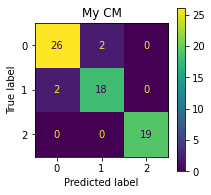

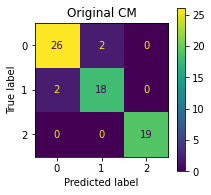

In [51]:
showConfussionMatrix(y_test, my_y_pred, "My CM")
showConfussionMatrix(y_test, y_pred, "Original CM")

Looking at the heatmap of the dataframe correlation.

<AxesSubplot:>

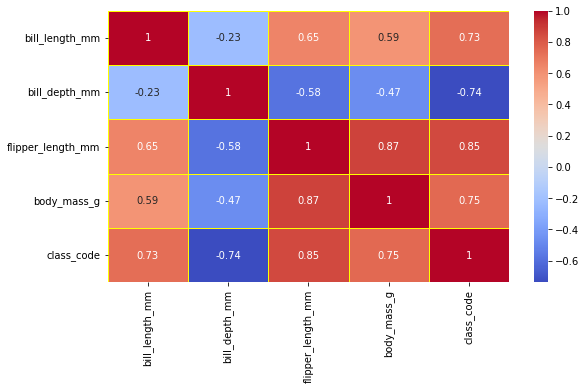

In [52]:
plt.figure (figsize=(9,5))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,linewidths=.8,linecolor="yellow")